# Customer Sentiment Analysis

## Packages and Imports

In [ ]:
!pip install datasets
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 95.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [ ]:
import pandas as pd
import torch
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import Trainer, TrainingArguments, BertForSequenceClassification, AdamW
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preprocessing

In [ ]:
df1 = pd.read_csv("/kaggle/input/sentimentdata/playstore_data.csv")
df2 = pd.read_csv("/kaggle/input/sentimentdata/yt_data.csv")

In [ ]:
df1.head()

,User,Review,Rating,Date,label
0,A Google user,bad app design. too many animation for it's ow...,1,2025-03-06 19:40:52,0
1,A Google user,"WorldLink Support Team, I hope this message fi...",1,2025-01-20 20:10:56,0
2,A Google user,This app is so bugged. I tried MAC filtering a...,1,2023-05-27 20:21:03,0
3,A Google user,The internet service is worst. Its a marketing...,1,2022-11-07 18:42:15,0
4,A Google user,The app is too slow that I can't even explain....,1,2021-05-15 18:38:53,0


In [ ]:
df2.head()

,Channel Name,Video Name,Review,User,Date,label
0,WorldLink Communications,"Get access to best features for support, refer...",How to extend ????,@kenichiff1505,2023-10-20T13:20:00Z,0
1,WorldLink Communications,"Get access to best features for support, refer...",Is your name Google? Because you've got everyt...,@rpmgaming5589,2023-10-17T11:52:02Z,1
2,WorldLink Communications,"Get access to best features for support, refer...",Wtf?? K aako cha update ma kina garni update i...,@Code-Matters,2023-10-15T10:36:23Z,0
3,WorldLink Communications,Rajesh Hamal & WorldLink Link Up!!,worst internet and service is just another nig...,@bhaladmi3720,2022-04-20T13:34:48Z,1
4,WorldLink Communications,Stupa to Stupa Race 2023 - WorldLink,Hello,@Prx713,2023-02-22T03:17:56Z,2


In [ ]:
df1["label"].value_counts()

label
0    5626
3    4225
2     711
Name: count, dtype: int64

Resolving the error in labels

In [ ]:
df1['label'] = df1['label'].replace(3, 1)

In [ ]:
df2["label"].value_counts()

label
1    1493
2     778
0     584
Name: count, dtype: int64

Seeing the trends of reviews of customers where we can see that the reviews are increasing after period of 2021 stating the rise of popularity of worldlink

<Figure size 1000x600 with 0 Axes>

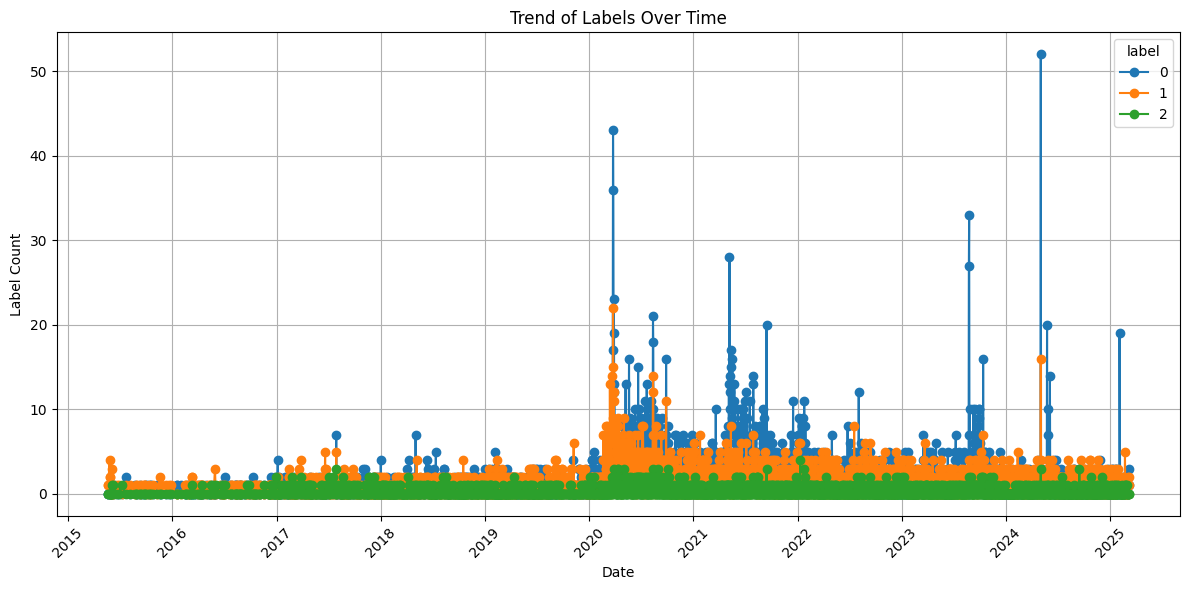

In [ ]:
# Convert the 'Date' column to datetime
df1['Date'] = pd.to_datetime(df1['Date'])

# Group by date and label, and count the occurrences of each label per day
label_trend = df1.groupby([df1['Date'].dt.date, 'label']).size().reset_index(name='count')

# Pivot the DataFrame to have 'Date' as index and labels as columns
pivot_df1 = label_trend.pivot_table(index='Date', columns='label', values='count', fill_value=0)

# Plot the trend
plt.figure(figsize=(10, 6))
pivot_df1.plot(kind='line', marker='o', figsize=(12, 6))

# Customize the plot
plt.title('Trend of Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Label Count')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

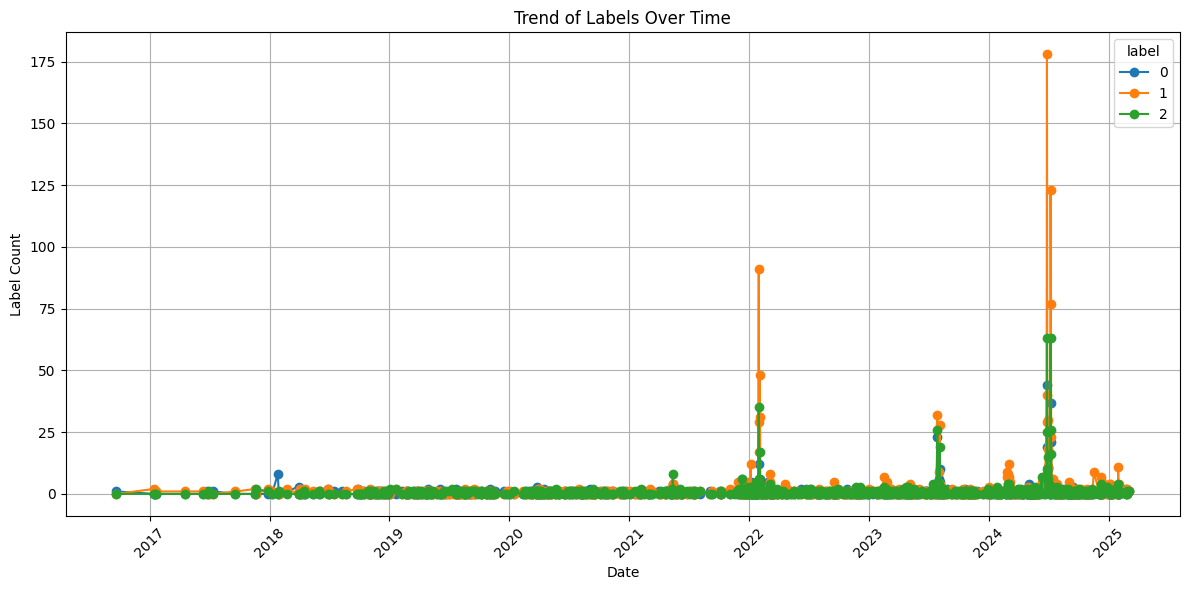

In [ ]:
# Convert the 'Date' column to datetime
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by date and label, and count the occurrences of each label per day
label_trend = df2.groupby([df2['Date'].dt.date, 'label']).size().reset_index(name='count')

# Pivot the DataFrame to have 'Date' as index and labels as columns
pivot_df2 = label_trend.pivot_table(index='Date', columns='label', values='count', fill_value=0)

# Plot the trend
plt.figure(figsize=(10, 6))
pivot_df2.plot(kind='line', marker='o', figsize=(12, 6))

# Customize the plot
plt.title('Trend of Labels Over Time')
plt.xlabel('Date')
plt.ylabel('Label Count')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Preprocessing and Combining both comment and playstore reviews

In [ ]:
df2 = df2.drop(['Channel Name', 'User','Date','Video Name'], axis=1)

In [ ]:
df1 = df1.drop([ 'User','Date','Rating'], axis=1)

In [ ]:
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [ ]:
df.head()

,Review,label
0,bad app design. too many animation for it's ow...,0
1,"WorldLink Support Team, I hope this message fi...",0
2,This app is so bugged. I tried MAC filtering a...,0
3,The internet service is worst. Its a marketing...,0
4,The app is too slow that I can't even explain....,0


In [ ]:
df["label"].value_counts()

label
0    6210
1    5718
2    1489
Name: count, dtype: int64

In [ ]:
df['label'].value_counts(normalize=True)

label
0    0.462846
1    0.426176
2    0.110979
Name: proportion, dtype: float64

In [ ]:
df['word_count'] = df['Review'].apply(lambda x: len(x.split()))

In [ ]:
pos = df[df["label"]== 1]
neg = df[df["label"]== 0]
neutral = df[df["label"]== 2]

In [ ]:
pos['word_count']

26       60
33       19
38        9
43        7
44       86
         ..
13409     1
13410     5
13412     2
13413     8
13416     5
Name: word_count, Length: 5718, dtype: int64

In [ ]:
# Plot for Positive Reviews (Label 2)
fig_pos = px.histogram(pos, x="word_count", nbins=50,
                       title="Positive Text Word Count",
                       labels={'text_word_count': 'Text Length'},
                       color_discrete_sequence=['red'])
fig_pos.update_layout(
    xaxis_title='Text Length',
    yaxis_title='Count'
)
fig_pos.show()

# Plot for Negative Reviews (Label 0)
fig_neg = px.histogram(neg, x="word_count", nbins=50,
                       title="Negative Text Word Count",
                       labels={'text_word_count': 'Text Length'},
                       color_discrete_sequence=['green'])
fig_neg.update_layout(
    xaxis_title='Text Length',
    yaxis_title='Count'
)
fig_neg.show()

# Plot for Neutral Reviews (Label 1)
fig_neutral = px.histogram(neutral, x="word_count", nbins=50,
                           title="Neutral Text Word Count",
                           labels={'text_word_count': 'Text Length'})
fig_neutral.update_layout(
    xaxis_title='Text Length',
    yaxis_title='Count'
)
fig_neutral.show()

Seeing the wordcount of the reviews, we can see that people tend to be more vocal when conveying a negative message

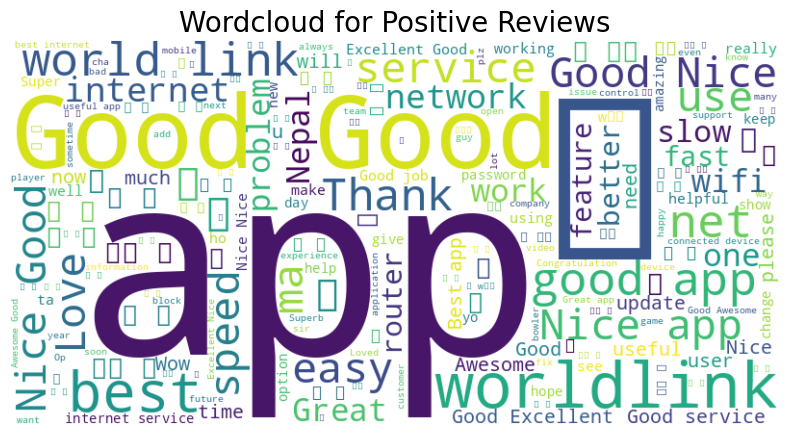

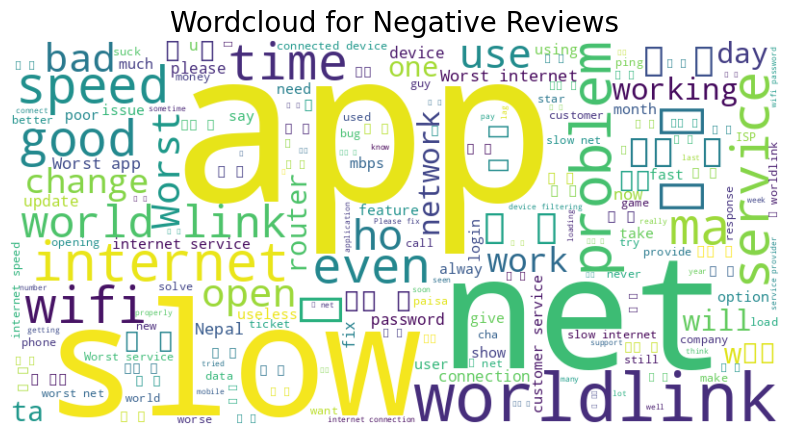

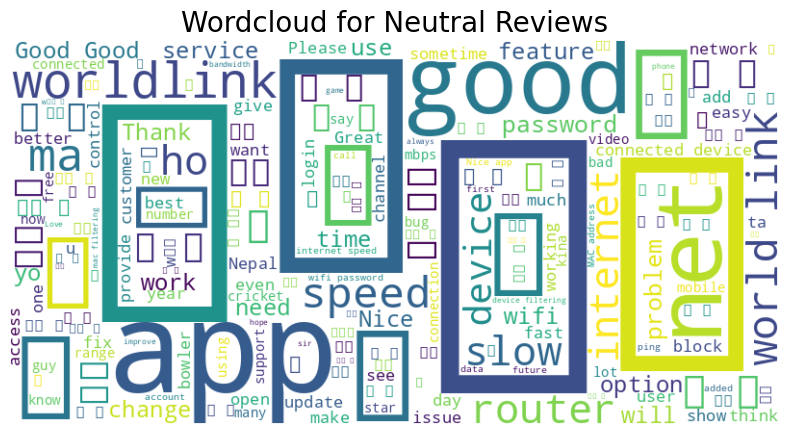

In [ ]:


# Function to create a wordcloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()


plot_wordcloud(pos['Review'], 'Wordcloud for Positive Reviews')

plot_wordcloud(neg['Review'], 'Wordcloud for Negative Reviews')

plot_wordcloud(neutral['Review'], 'Wordcloud for Neutral Reviews')


In [ ]:
# Load tokenizer and model for BERT multilingual uncased
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased",hidden_dropout_prob=0.3).to(device)

# Initialize the sentiment analysis pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Because the number of neutral is far less than both positive and negative sentiments. With this amount of data, we will not take neutral reviews for the model training and do sentiment analysis for positive and negative sentiments only.

In [ ]:
df = df[df['label'] != 2]

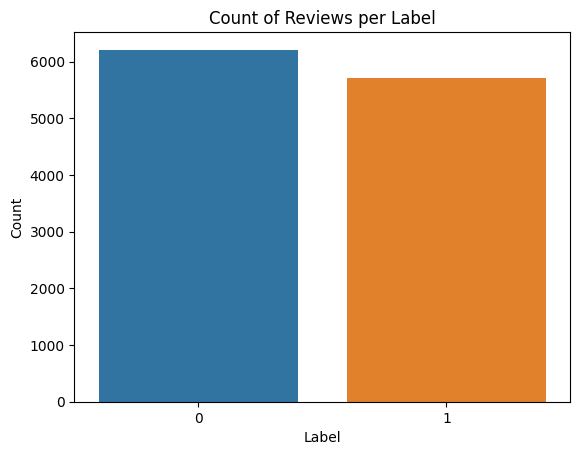

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt
# Create the countplot
sns.countplot(x='label', data=df)
# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Reviews per Label')
# Display the plot
plt.show()


The labels for positive (1) and negative (0) are fairly balanced

Data Cleaning to remove punctuation and special characters as well as extra space removal

In [ ]:

import re

# Function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation & special characters
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespaces
        return text
    return text






In [ ]:
df["Review"] = df["Review"].apply(clean_text)

In [ ]:
df.head()

,Review,label,word_count
0,bad app design too many animation for its own ...,0,71
1,WorldLink Support Team I hope this message fin...,0,84
2,This app is so bugged I tried MAC filtering an...,0,84
3,The internet service is worst Its a marketing ...,0,89
4,The app is too slow that I cant even explain M...,0,63


In [ ]:
df.shape


(11928, 3)

In [ ]:
df = df.drop([ 'word_count'], axis=1)

Splitting the dataset

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
train_df['label'].value_counts()


label
0    4954
1    4588
Name: count, dtype: int64

In [ ]:
test_df['label'].value_counts()

label
0    1256
1    1130
Name: count, dtype: int64

### Tokenization

In [ ]:


df_trainset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

final_dataset = DatasetDict({
    'train':df_trainset,
    'test': test_dataset,
})

In [ ]:
def tokenize_texts(batch):
    return tokenizer(batch['Review'], truncation=True, padding='max_length', max_length=128, return_tensors='pt')


In [ ]:
encoded_data = final_dataset.map(tokenize_texts, batched=True, batch_size=None)

Map:   0%|          | 0/9542 [00:00<?, ? examples/s]

Map:   0%|          | 0/2386 [00:00<?, ? examples/s]

### Model Training

In [ ]:
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=num_labels, from_tf=True)
         .to(device))

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


###

In [ ]:

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)  # Get the predicted class labels

    # Calculate accuracy, precision, recall, f1 score
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
model_name = "google-bert/bert-base-multilingual-uncased"

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=False,  # Ensure it does not try to reload a saved model
    report_to="none"
)

optimizer = AdamW(model.parameters(), lr=4e-5,weight_decay=0.01)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:640: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [ ]:
trainer = Trainer(
    model=model,  # The model you are training
    args=training_args,  # The training arguments
    compute_metrics=compute_metrics,  # Your custom metric computation
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["test"],
    tokenizer = tokenizer
)

<ipython-input-76-533a35d38e6d>:1: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.529100,0.467991,0.807209,0.827182,0.807209,0.805742
2,0.545300,0.437108,0.844091,0.845925,0.844091,0.844196
3,0.700300,0.692118,0.526404,0.277101,0.526404,0.363077
4,0.693400,0.694298,0.526404,0.277101,0.526404,0.363077
5,0.518800,0.510183,0.792540,0.813481,0.792540,0.787001
6,0.546800,0.552253,0.730930,0.790506,0.730930,0.711414
7,0.597300,0.540082,0.754820,0.790543,0.754820,0.743599
8,0.572200,0.551572,0.745599,0.782463,0.745599,0.733248
9,0.551900,0.438672,0.840319,0.840425,0.840319,0.840354
10,0.408900,0.421977,0.846605,0.847376,0.846605,0.846703


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



TrainOutput(global_step=11930, training_loss=0.5364727810462383, metrics={'train_runtime': 1621.0793, 'train_samples_per_second': 58.862, 'train_steps_per_second': 7.359, 'total_flos': 6276514225612800.0, 'train_loss': 0.5364727810462383, 'epoch': 10.0})

### Metrics and Evaluation

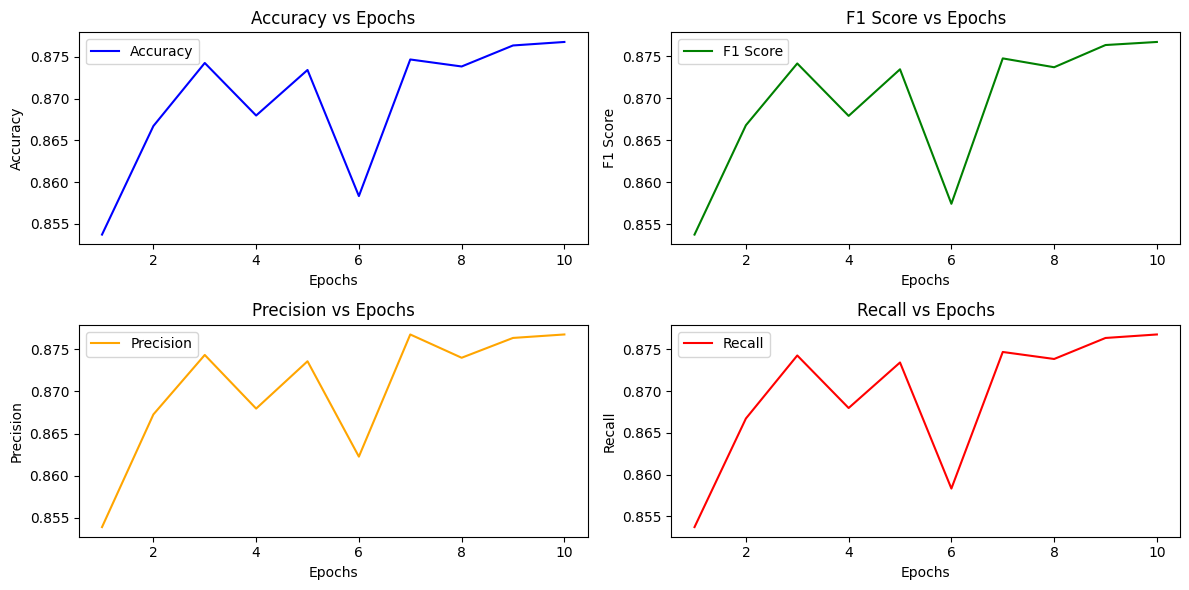

In [ ]:
log_history = trainer.state.log_history  # This will contain all logs for each evaluation

# Collecting metrics for plotting
epochs = []
accuracy = []
f1 = []
precision = []
recall = []

# Iterate through the logs and collect metrics for each epoch
for log in log_history:
    if 'eval_accuracy' in log:  # Ensure it's an evaluation log
        epochs.append(log['epoch'])  # Track the epoch number
        accuracy.append(log['eval_accuracy'])
        f1.append(log['eval_f1'])
        precision.append(log['eval_precision'])
        recall.append(log['eval_recall'])

# Plot the metrics using matplotlib
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, label="Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

# Plot F1 Score
plt.subplot(2, 2, 2)
plt.plot(epochs, f1, label="F1 Score", color='green')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Epochs")
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precision, label="Precision", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision vs Epochs")
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, recall, label="Recall", color='red')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall vs Epochs")
plt.legend()


plt.tight_layout()
plt.show()


The dip in mid epochs might be due to the challenges in adapting to multilingual aspect or noisy data but the recovery reaffirms the effectiveness of finetuning strategy. Overall, the final metrics validate the model’s suitability for multilingual sentiment analysis

In [ ]:
preds_output = trainer.predict(encoded_data["test"])

In [ ]:
preds_output.metrics

{'test_loss': 0.4219770133495331,
 'test_accuracy': 0.8466051969823973,
 'test_precision': 0.8473756287066952,
 'test_recall': 0.8466051969823973,
 'test_f1': 0.8467025276147147,
 'test_runtime': 9.8377,
 'test_samples_per_second': 242.537,
 'test_steps_per_second': 30.393}

In [ ]:
trainer.save_model("/kaggle/working/final")

In [ ]:
custom_text = "Everyday one iphone to the worldlink user great n congratulations worldlink"
pipe = pipeline("text-classification", model='/content/final')
preds = pipe(custom_text)

Device set to use cuda:0


In [ ]:
preds

[{'label': 'LABEL_1', 'score': 0.982239842414856}]